https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook#Econometric-approach

# Topic 9 - Part 1. Time series analysis in Python

## 1. Introduction

### Loading Data

In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
#plt.style.use('fivethirtyeight')

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline

As an example, let's look into two datasets where one is ads watched per hour and the other one is in-game currency spend per day

In [2]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
cur = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

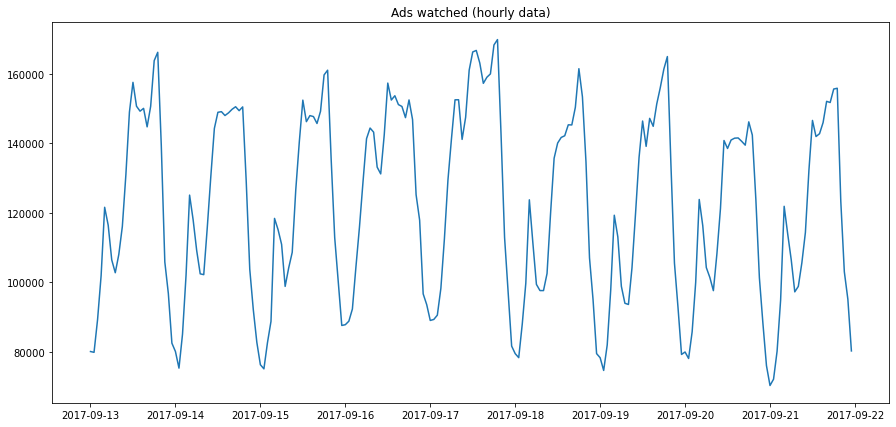

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.show()

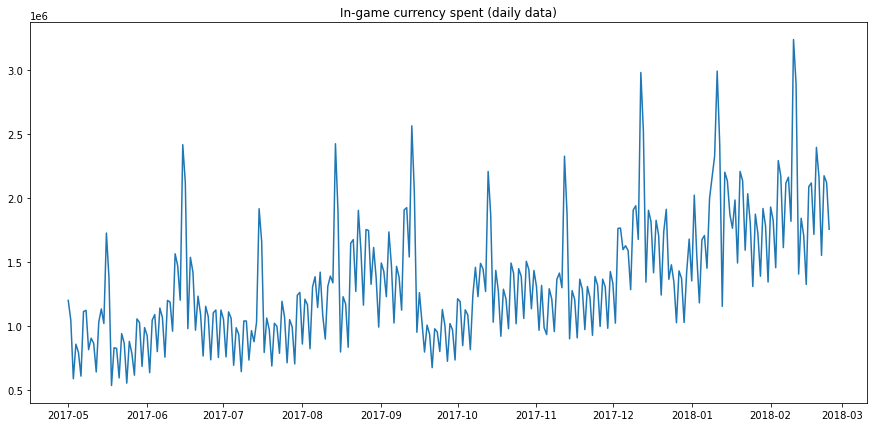

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(cur.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.show()

### Evaluation Metrics

In [5]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 2. Move, Smooth, Evaluate

### Moving Average

Let's start with a naive hypothesis: "we will assume that the future value of our variable depends on the average of its  k  previous values. Therefore, we will start with the moving average."

One major benefits of using moving average is that it can smooth out the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [6]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

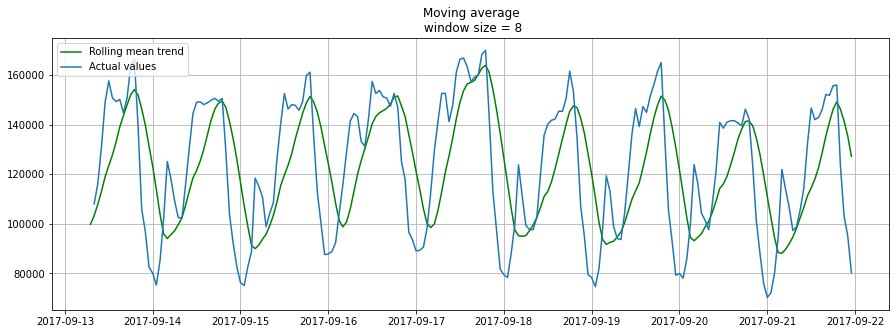

In [7]:
# smooth by 8 hours

plotMovingAverage(ads, 8) 

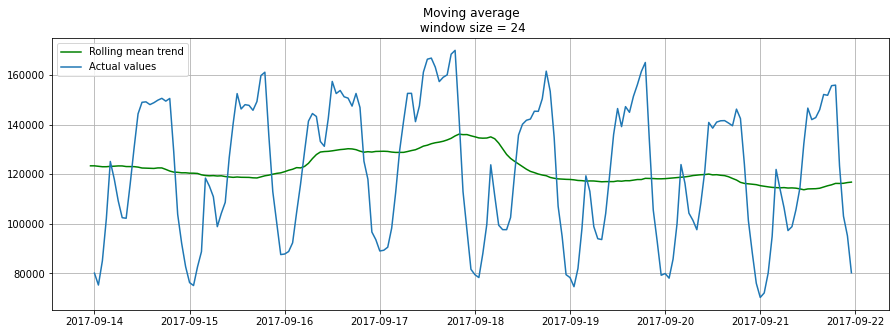

In [8]:
plotMovingAverage(ads, 24) 

When we applied daily smoothing on hourly data, we could clearly see the dynamics of ads watched. During the weekends, the values are higher (more time to play on the weekends) while fewer ads are watched on weekdays.

We can also plot confidence intervals for our smoothed values.

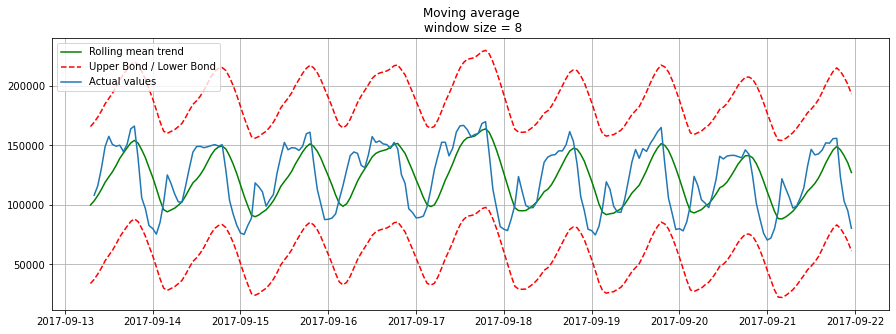

In [9]:
plotMovingAverage(ads, 8, plot_intervals=True)

Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe.

In [10]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

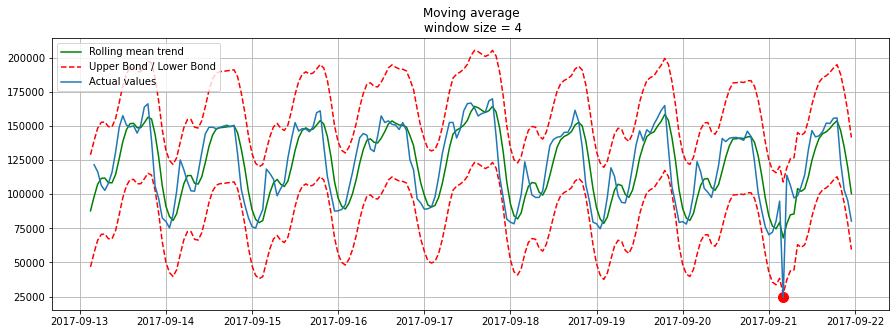

In [11]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

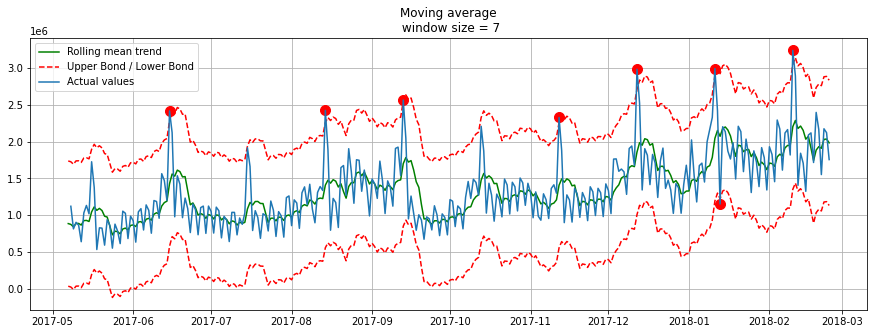

In [12]:
# plot the second ts

plotMovingAverage(cur, 7, plot_intervals=True, plot_anomalies=True)

Here, we can see the downside of our simple approach -- it did not capture the monthly seasonality in our data and marked almost all 30-day peaks as anomalies. If you want to avoid false positives, it is best to consider more complex models.

### Exponential Smoothing

Now, let's see what happens if, instead of weighting the last  k  values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. 

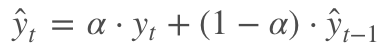

Here the model value is a weighted average between the current true value and the previous model values. The  α  weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller  α  is, the more influence the previous observations have and the smoother the series is.

In [13]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [14]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

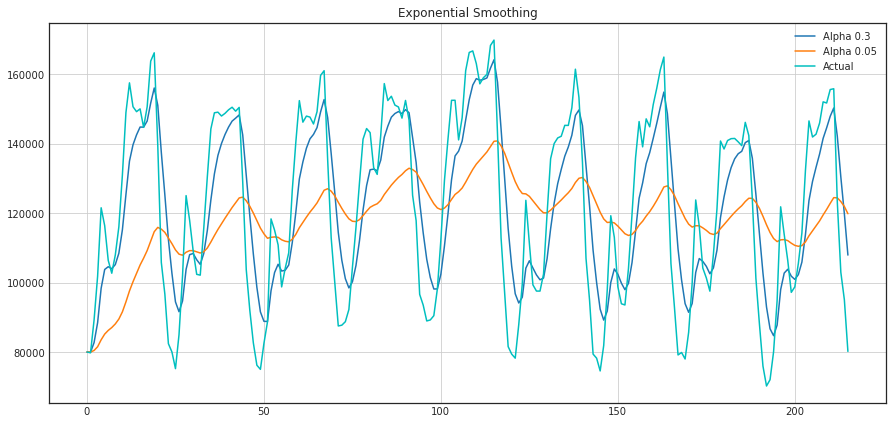

In [15]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

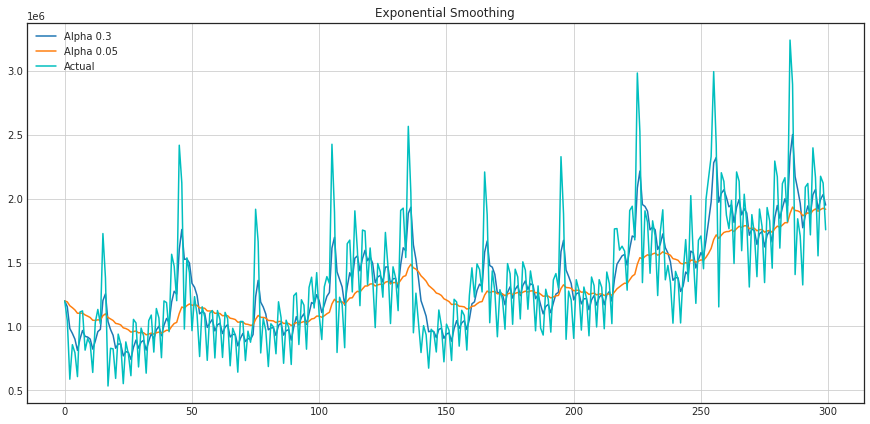

In [16]:
plotExponentialSmoothing(cur.GEMS_GEMS_SPENT, [0.3, 0.05])

### Double Exponential Smoothing (Optional)

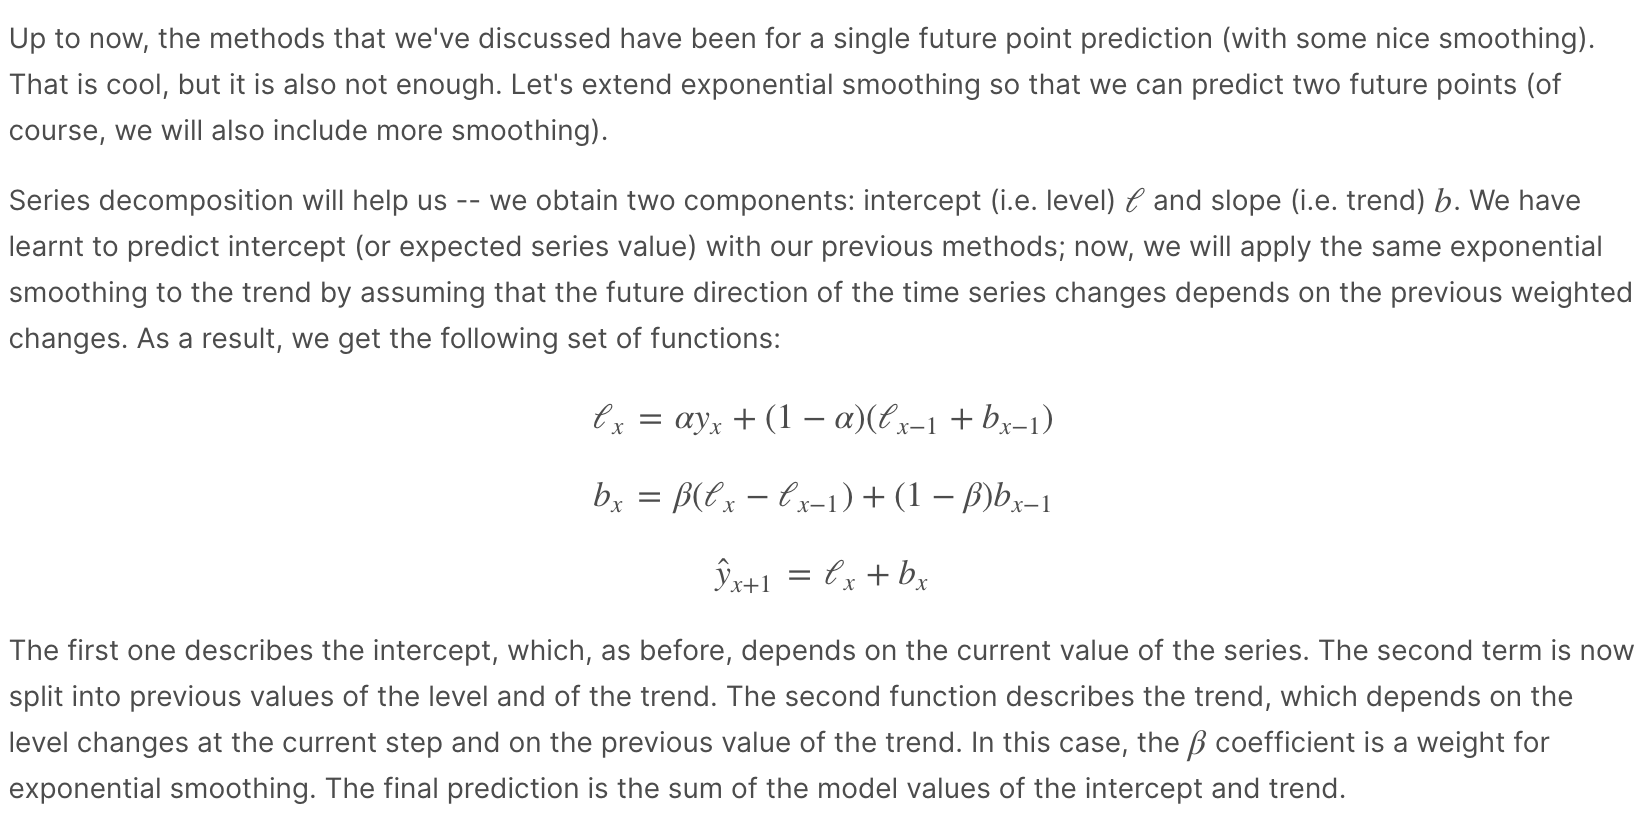

In [17]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

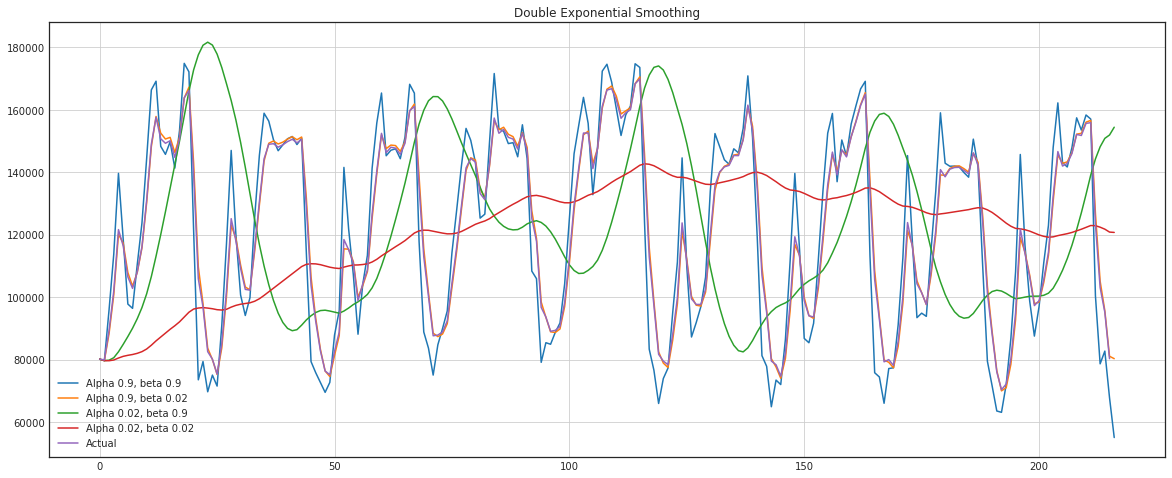

In [18]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])


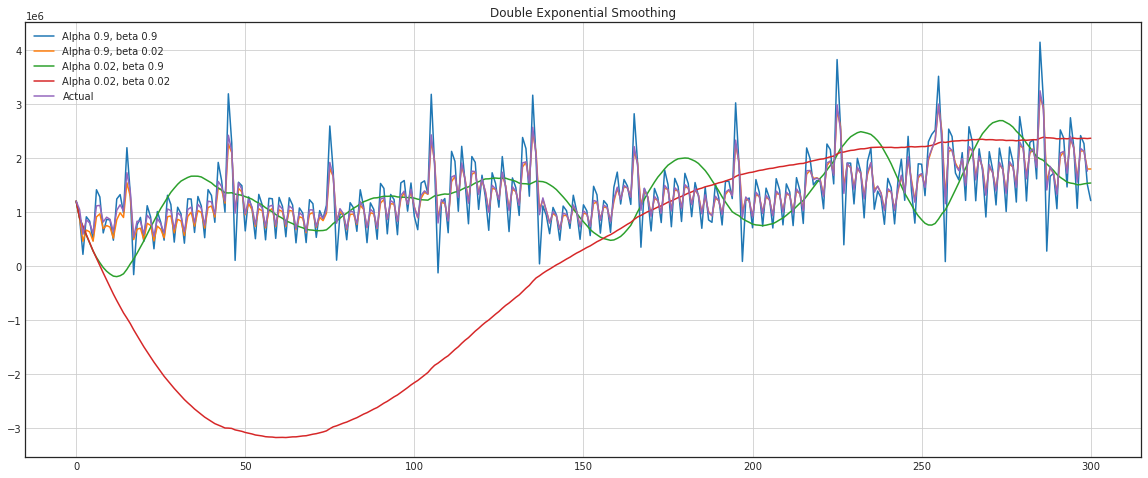

In [19]:
plotDoubleExponentialSmoothing(cur.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])


Now we have to tune two parameters:  α  and  β . The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. Certain combinations of the parameters may produce strange results, especially if set manually. We'll look into choosing parameters automatically in a bit; before that, let's discuss triple exponential smoothing.

### Triple exponential smoothing a.k.a. Holt-Winters (Optional)

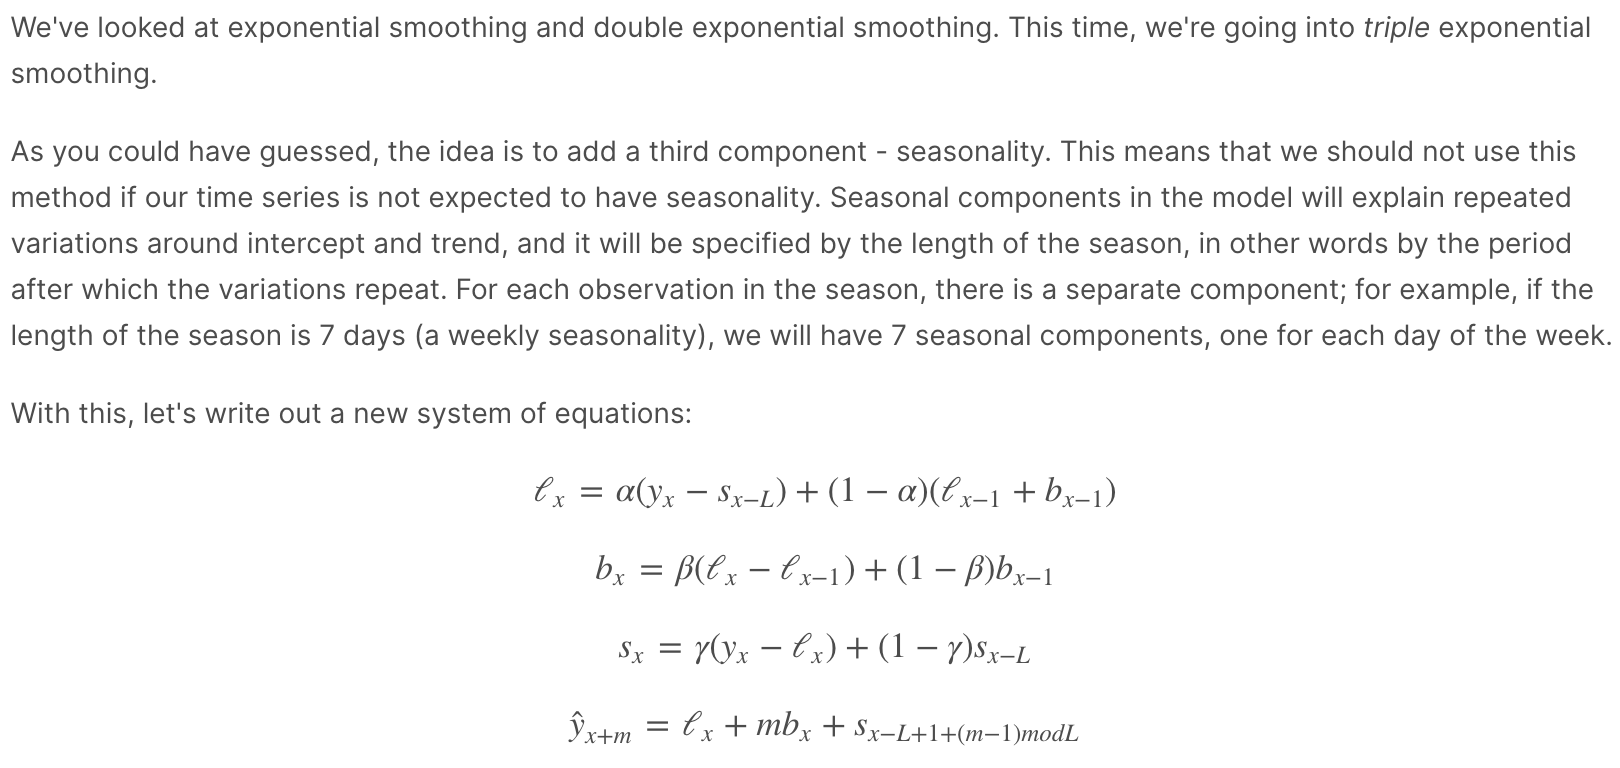

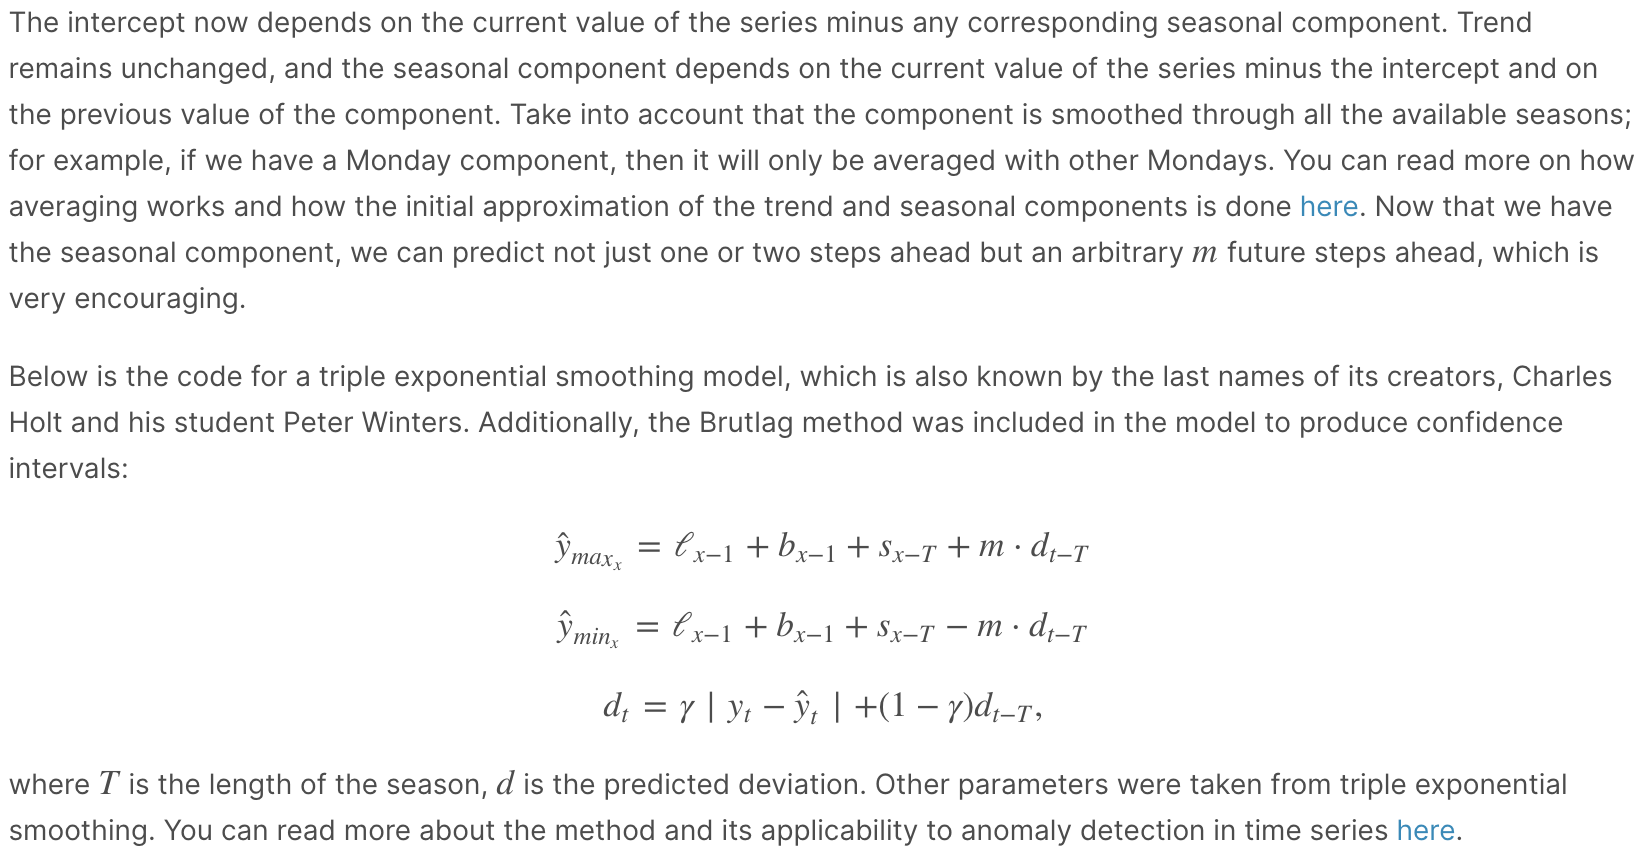

In [20]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [21]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

### Time Series Cross Validation

Before we start building a model, let's first discuss how to estimate model parameters automatically. As always, we have to choose a loss function suitable for the task that will tell us how closely the model approximates the data. Then, using cross-validation, we will evaluate our chosen loss function for the given model parameters, calculate the gradient, adjust the model parameters, and so on, eventually descending to the global minimum.

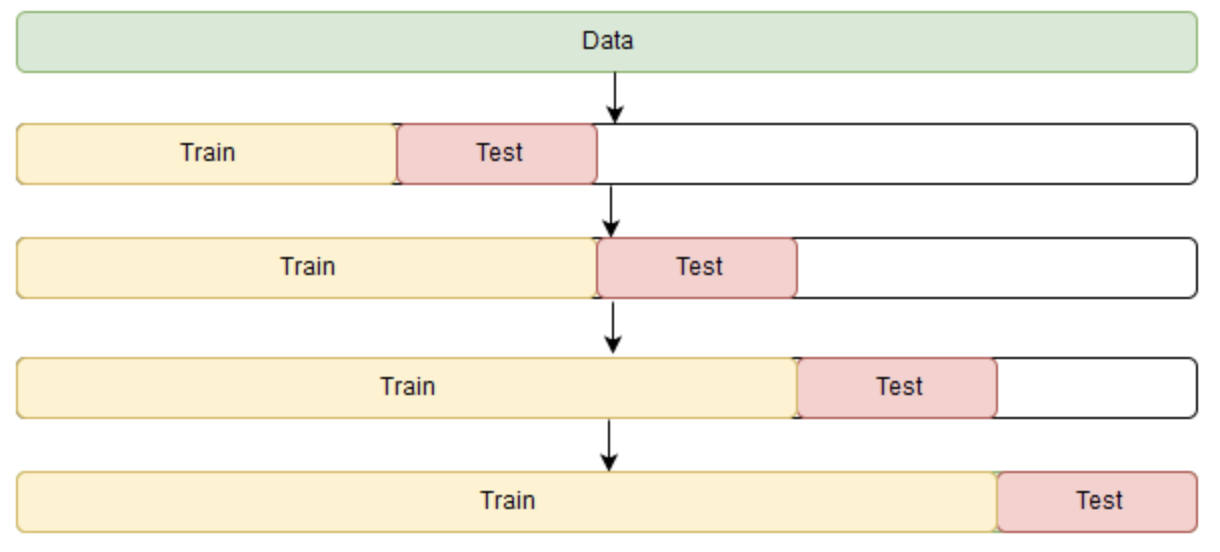

In [22]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

Now, knowing how to set up cross-validation, we can find the optimal parameters for the Holt-Winters model. Recall that we have daily seasonality in ads, hence the slen=24 parameter.

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [23]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)

model.triple_exponential_smoothing()

0.11676236693712227 0.0026881337430822994 0.055312622299154346
CPU times: user 1.04 s, sys: 7.89 ms, total: 1.05 s
Wall time: 1.05 s


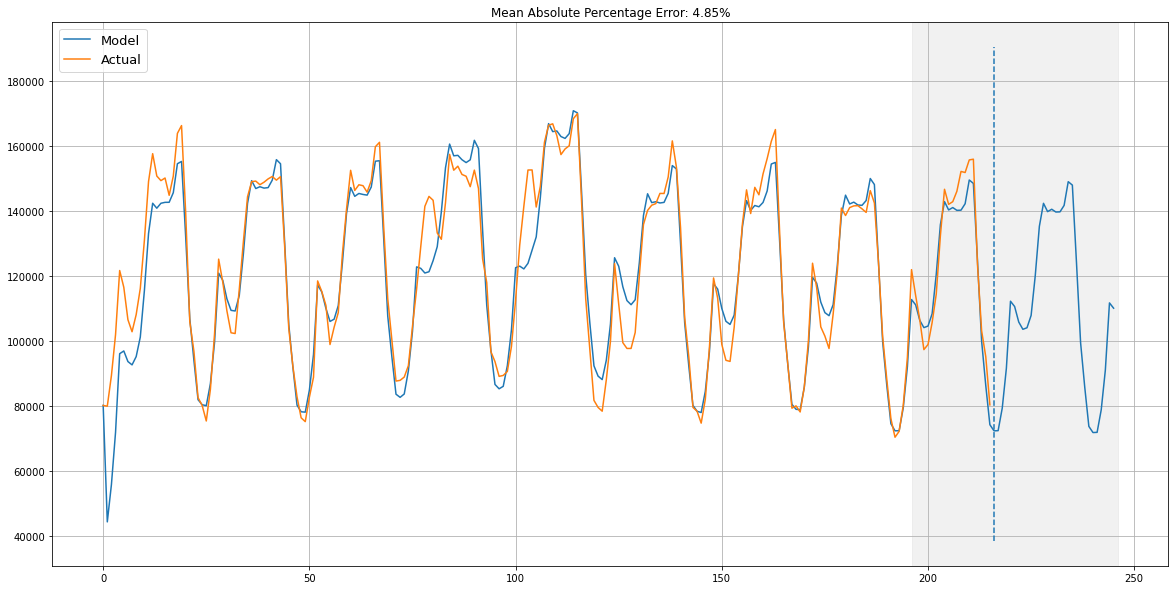

In [24]:
plotHoltWinters(ads.Ads)

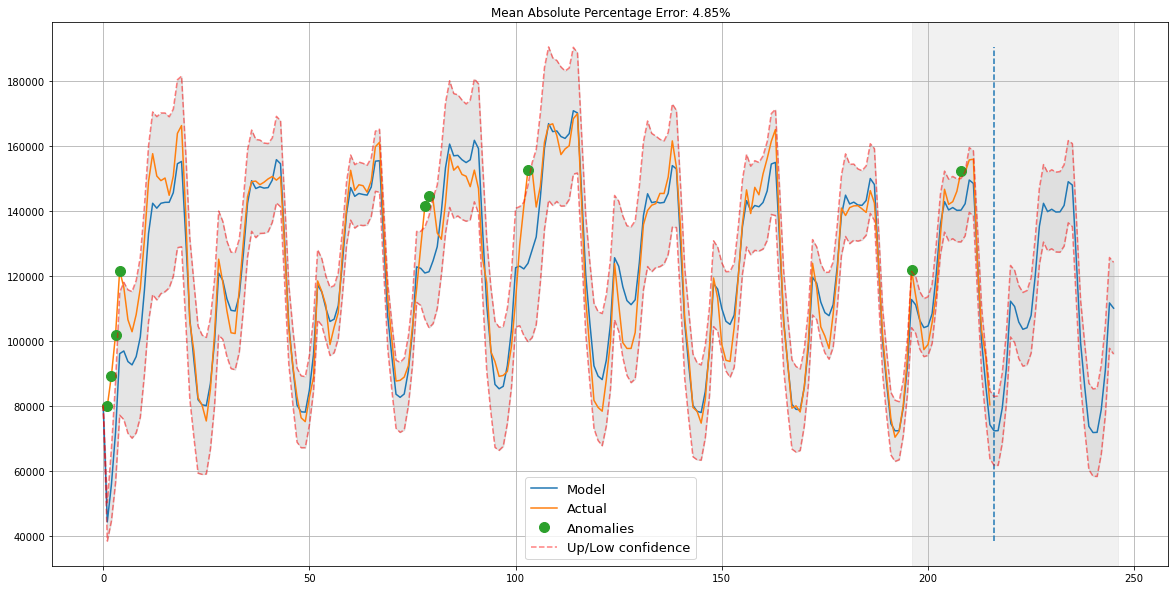

In [25]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Judging by the plots, our model was able to successfully approximate the initial time series, capturing the daily seasonality, overall downwards trend, and even some anomalies. If you look at the model deviations, you can clearly see that the model reacts quite sharply to changes in the structure of the series but then quickly returns the deviation to the normal values, essentially "forgetting" the past. This feature of the model allows us to quickly build anomaly detection systems, even for noisy series data, without spending too much time and money on preparing the data and training the model.

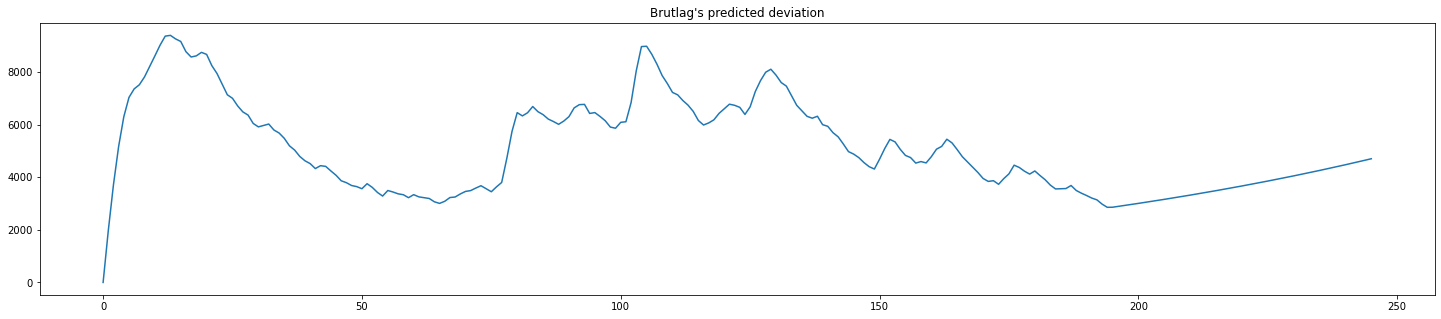

In [26]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

We'll apply the same algorithm for the second series which, as you may recall, has trend and a 30-day seasonality.

In [27]:
%%time
data = cur.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)

model.triple_exponential_smoothing()

0.013190344846993662 0.047616267647338284 0.0
CPU times: user 1.44 s, sys: 11.8 ms, total: 1.45 s
Wall time: 1.44 s


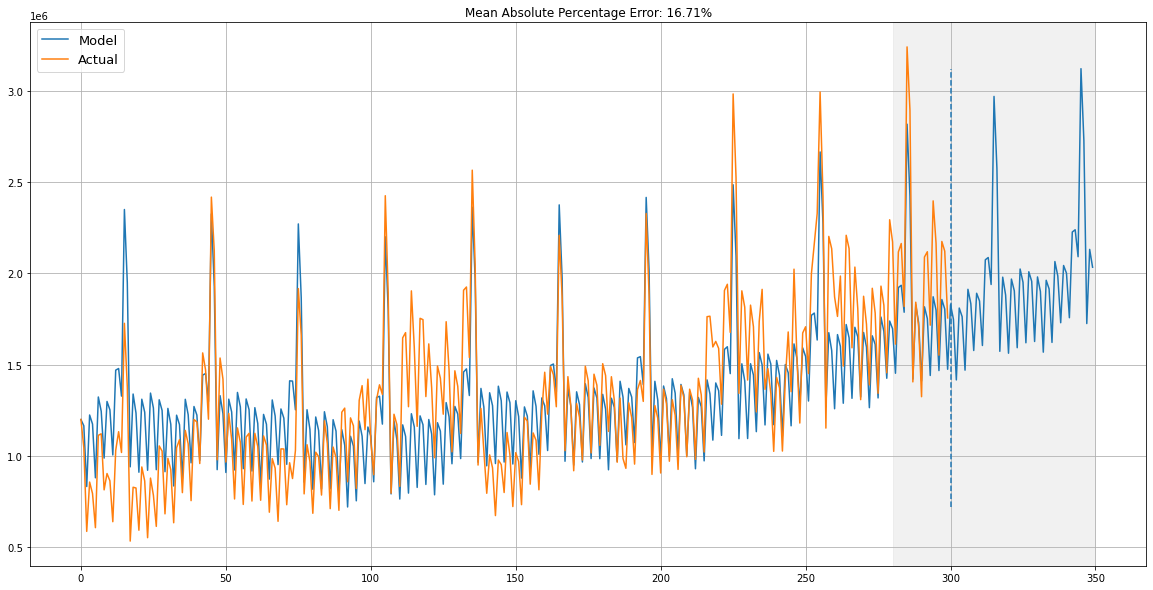

In [28]:
plotHoltWinters(cur.GEMS_GEMS_SPENT)

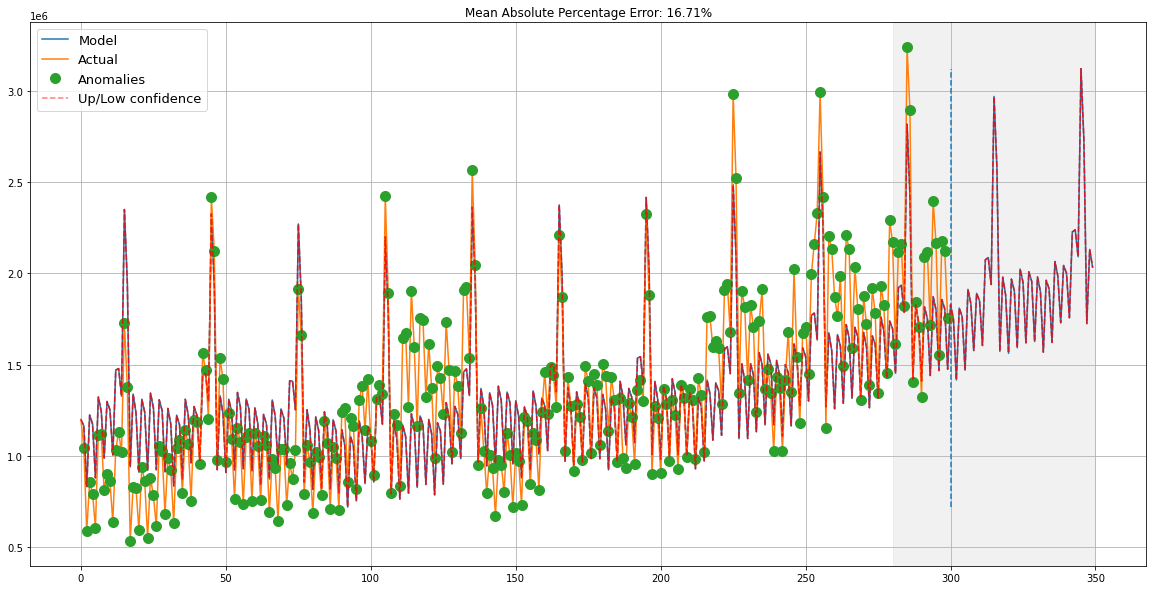

In [29]:
plotHoltWinters(cur.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

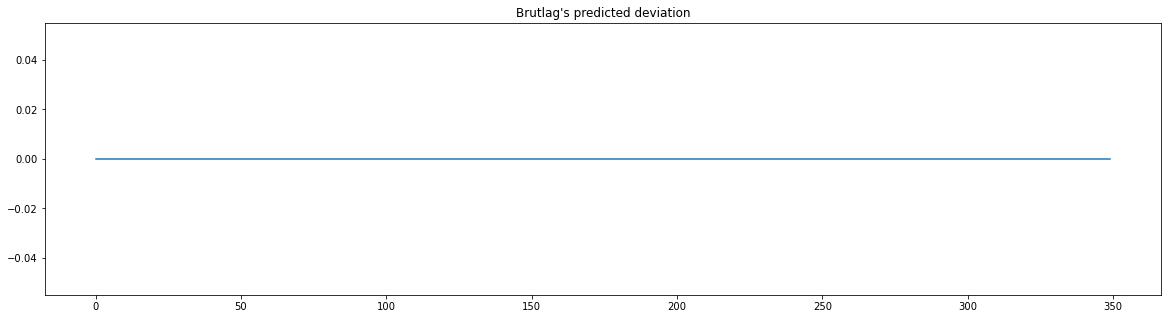

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## 3. Econometric Approch

### Stationarity

Before we start modeling, we should mention an important property of time series: stationarity. If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. And the covariance function does not depend on time; it should only depend on the distance between observations.



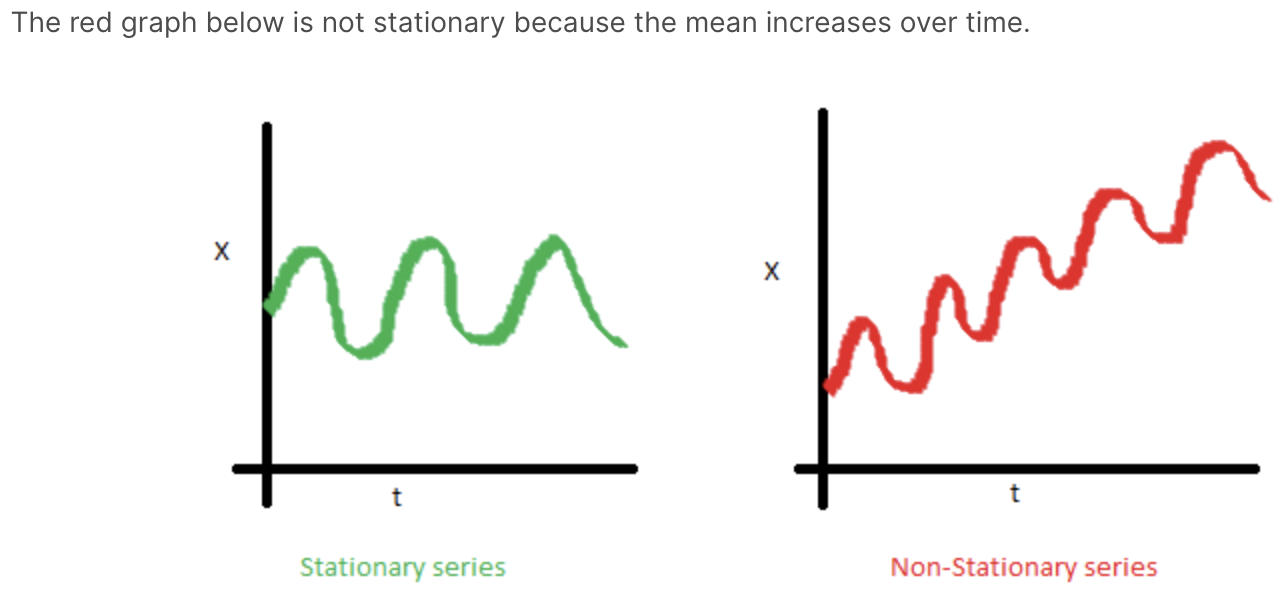
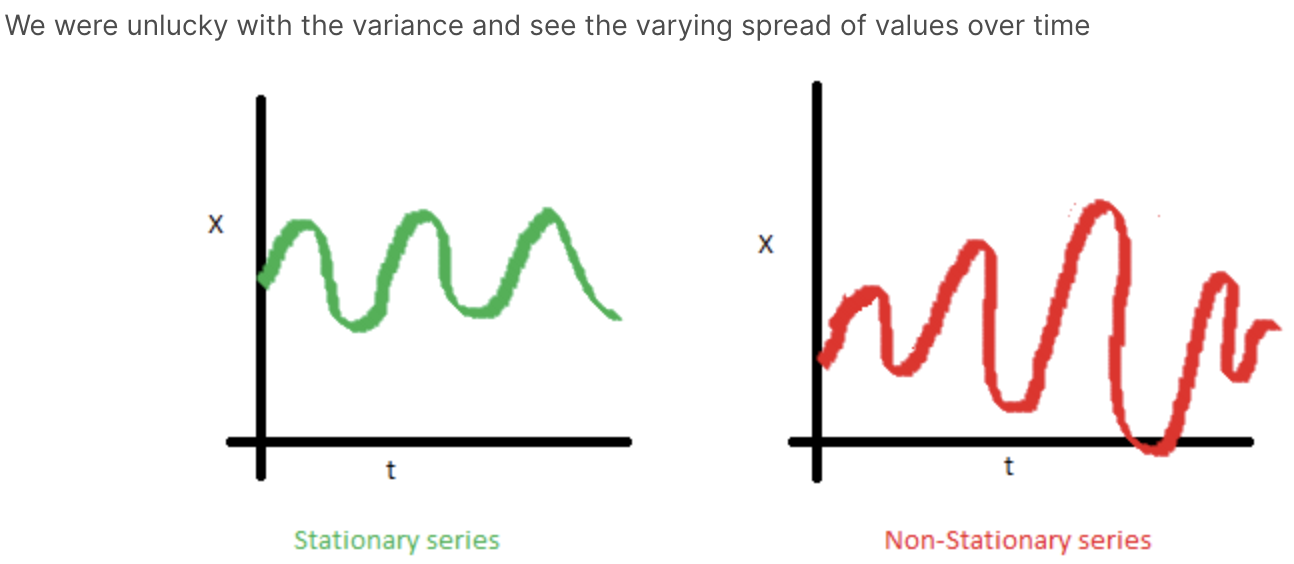
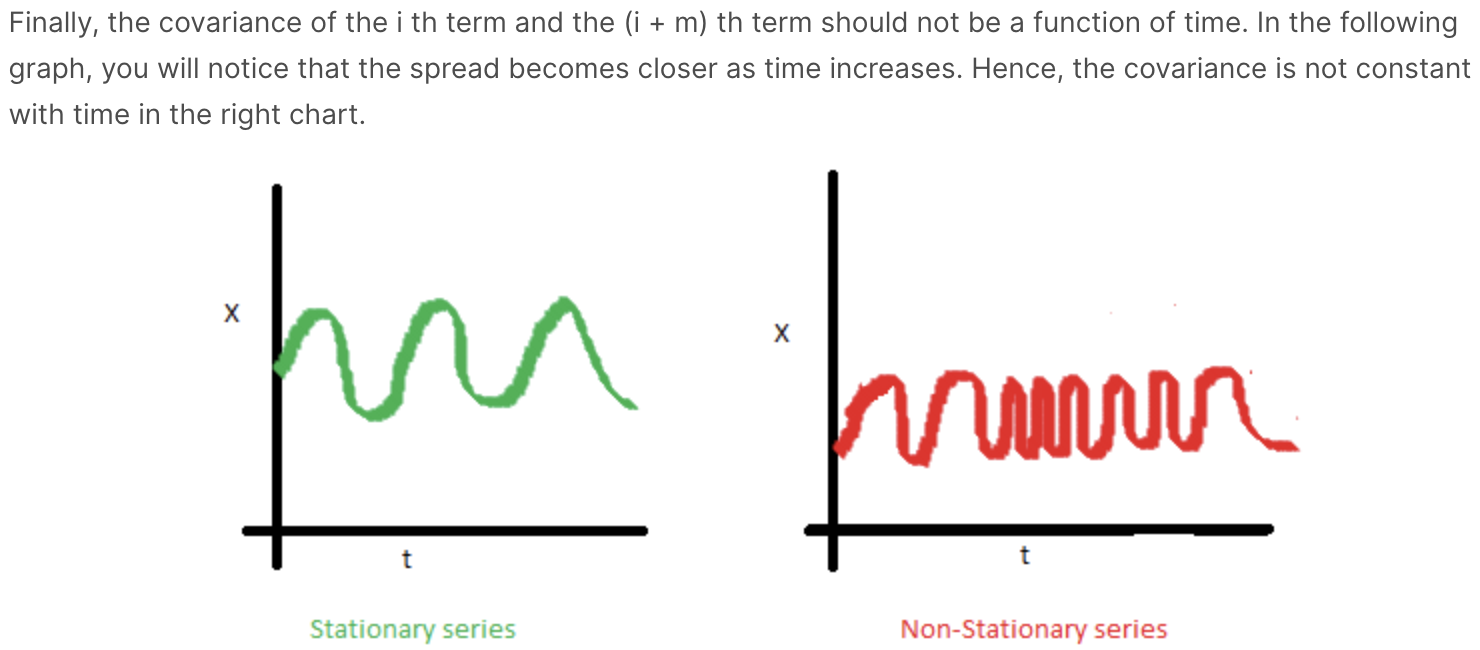

So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed.

Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

We will start from looking at white noise and random walks to learn how to get from one to the other for free.

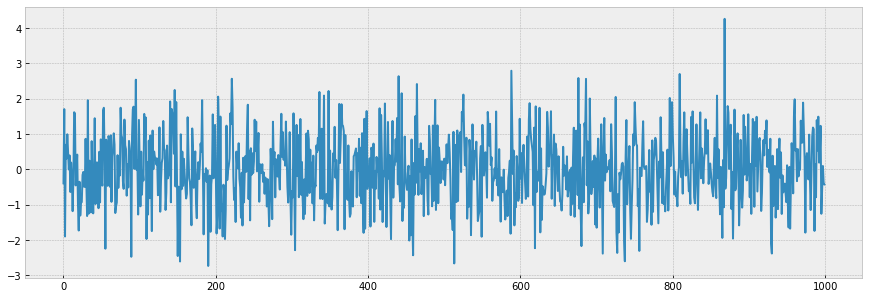

In [31]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

The process generated by the standard normal distribution is stationary and oscillates around 0 with with deviation of 1. Now, based on this process, we will generate a new one where each subsequent value will depend on the previous one:

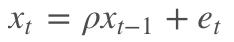

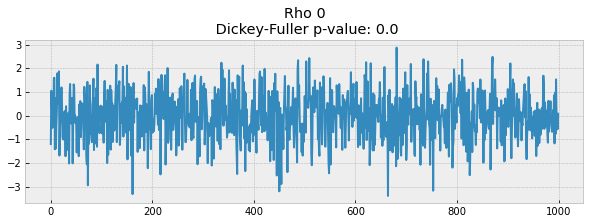

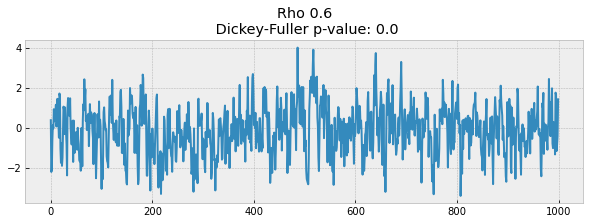

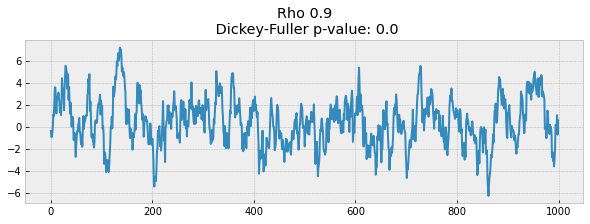

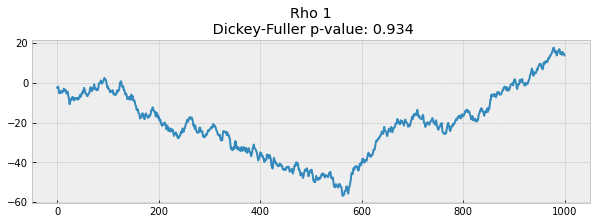

In [32]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

On the first plot, you can see the same stationary white noise as before. On the second plot with  ρ  increased to 0.6, wider cycles appeared, but it still appears stationary overall. The third plot deviates even more from the 0 mean but still oscillates about the mean. Finally, with  ρ=1 , we have a random walk process i.e. a non-stationary time series.

This happens because, after reaching the critical value, the series does not return to its mean value. If we subtract  xt−1 from then this is referred to as the first difference which will gives us stationary white noise.

This is the main idea behind the Dickey-Fuller test for stationarity of time series (testing the presence of a unit root). If we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1.

The null hypothesis of the test is that the time series is non-stationary, which was rejected on the first three plots and finally accepted on the last one. We have to say that the first difference is not always enough to get a stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots). In such cases, the augmented Dickey-Fuller test is used, which checks multiple lags at once.

We can fight non-stationarity using different approaches: various order differences, trend and seasonality removal, smoothing, and transformations like Box-Cox or logarithmic.

### Getting rid of non-stationarity and building SARIMA

Let's build an ARIMA model by walking through all the circles of hell stages of making a series stationary.

In [33]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

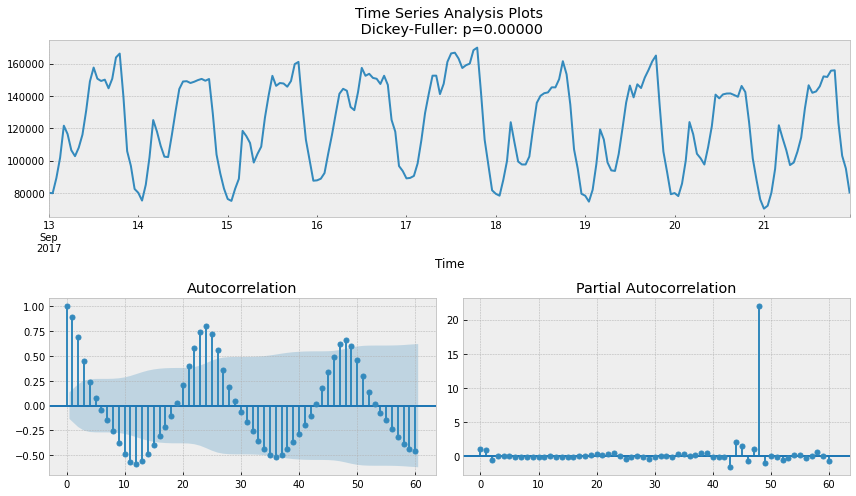

In [34]:
tsplot(ads.Ads, lags=60)

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself -- we do not have a visible trend, so the mean is constant and the variance is pretty much stable. 

The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

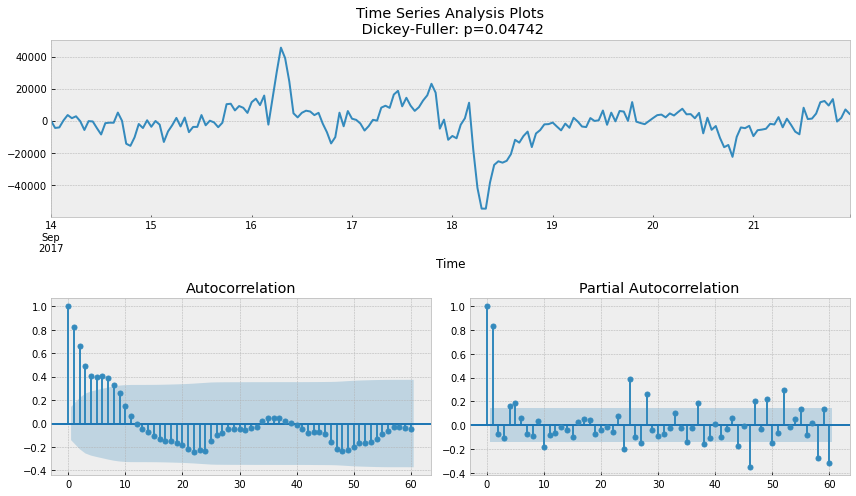

In [35]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

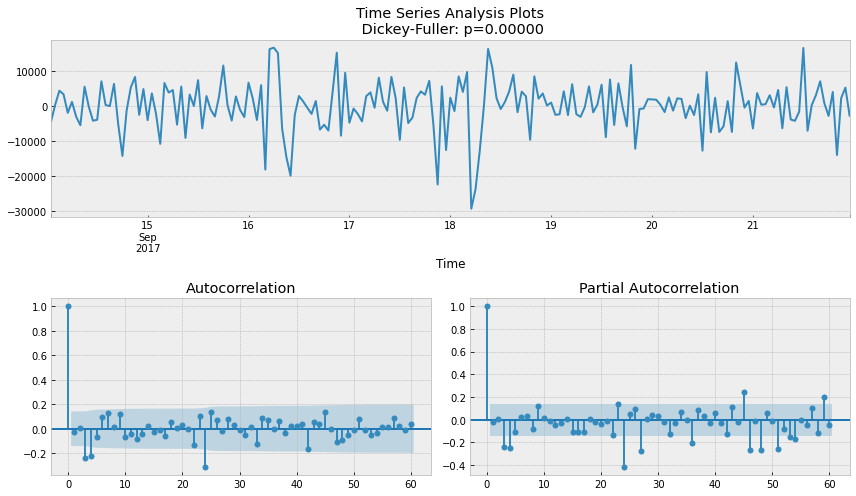

In [36]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Our series now looks like something undescribable, oscillating around zero. 

### ARIMA Modeling

We will explain this model by building up letter by letter. SARIMA(p,d,q)(P,D,Q,s), Seasonal Autoregression Moving Average model:

AR(p) - Autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as  p. To determine the initial  p , you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.

MA(q)  - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as q. The initial value can be found on the ACF plot with the same logic as before.

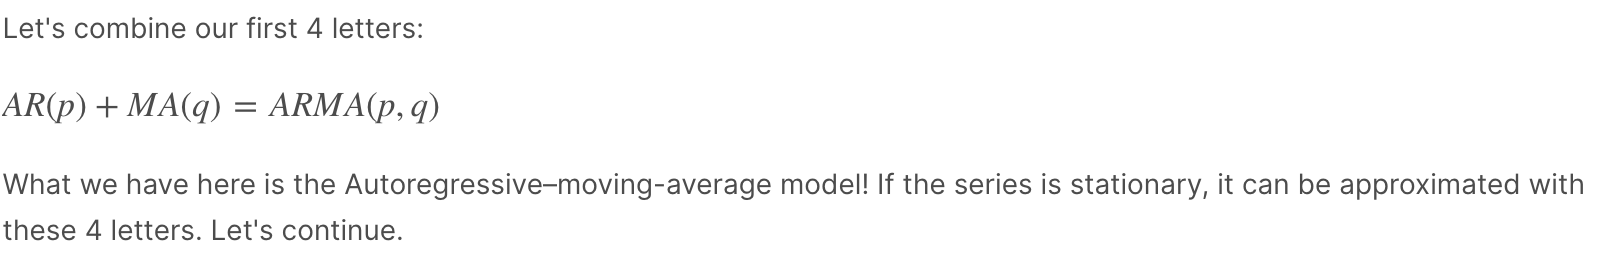

I(d) - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences. Adding this letter to the four gives us the  ARIMA  model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

S(s) - this is responsible for seasonality and equals the season period length of the series. With this, we have three parameters: (P,D,Q)
   - P: order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial P should be 2.
   - Q: similar logic using the ACF plot instead.
   - D: order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.


Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

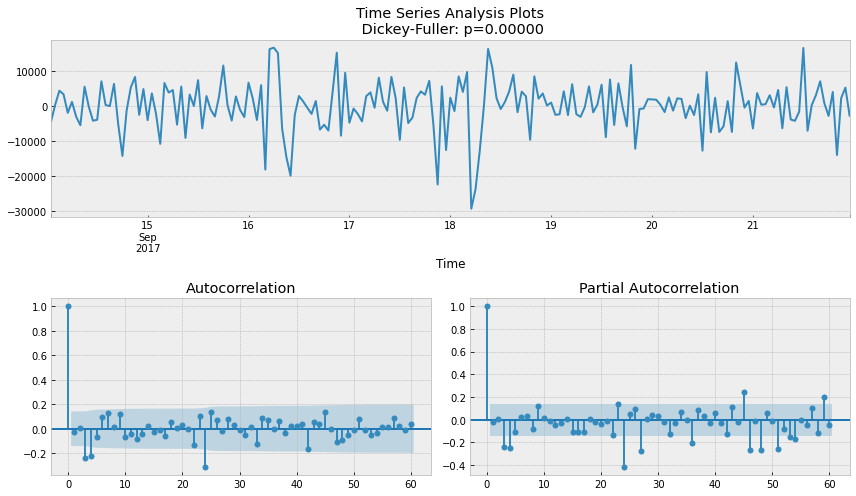

In [37]:
tsplot(ads_diff[24+1:], lags=60)

- p is most probably 4 since it is the first significant lag on the PACF
- d equals 1 because we had first differences
- q should be somewhere around 4 as well as seen on the ACF

- P might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- D again equals 1 because we performed seasonal differentiation
- Q is probably 1. The 24-th lag on ACF is significant while the 48-th is not.


In [38]:
# Let's test various models and see which one is better.

ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [39]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [40]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/

/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/

/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/st

CPU times: user 5min 43s, sys: 1.83 s, total: 5min 45s
Wall time: 1min


/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
result_table.head()

parameters          aic
0  (2, 3, 1, 1)  3888.642174
1  (3, 2, 1, 1)  3888.763568
2  (4, 2, 1, 1)  3890.279740
3  (3, 3, 1, 1)  3890.513196
4  (2, 4, 1, 1)  3892.302849

In [42]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Tue, 20 Jul 2021   AIC                           3888.642
Time:                                      15:01:53   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

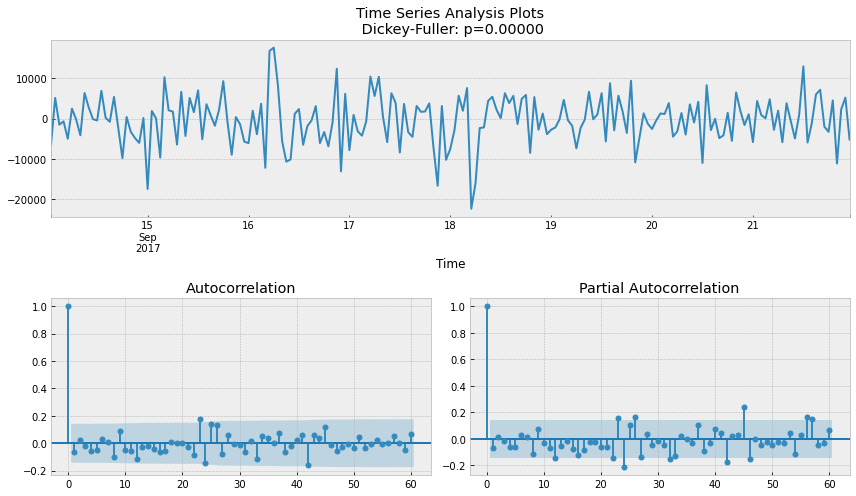

In [43]:
tsplot(best_model.resid[24+1:,], lags=60)

It is clear that the residuals are stationary, and there are no apparent autocorrelations. Let's make predictions using our model.

In [44]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

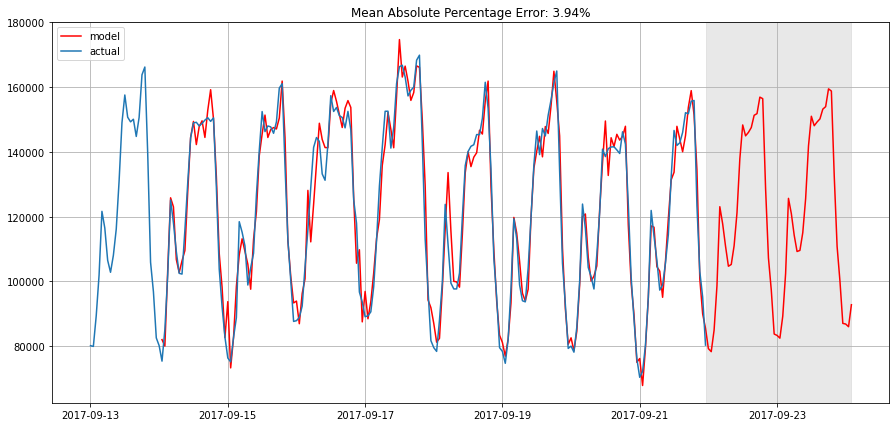

In [45]:
plotSARIMA(ads, best_model, 50)

In the end, we got very adequate predictions. Our model was wrong by 4.01% on average, which is very, very good.

## 4. Linear (and non-linear) Models on Time Series

This approach is not backed by theory and breaks several assumptions (e.g. Gauss-Markov theorem, especially for errors being uncorrelated), but it is very useful in practice and is often used in machine learning competitions.

### Feature Extraction

The model needs features, and all we have is a 1-dimentional time series. So what features can we exctract?
- lags of time series
- window statistics: max/min or avg/median value in a time series window
- date and time features: minute, hour, day, holiday or not
- target encoding
- forecasts from other models

### Lags of Time Series

Shifting the series  n  steps back, we get a feature column where the current value of time series is aligned with its value at time t−n.

If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back.

However, if something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [46]:
# Creating a copy of the initial datagrame to make various transformations 

data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [47]:
# Adding the lag of the target variable from 6 steps back up to 24

for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [48]:
# take a look at the new dataframe 

data.tail(7)

y     lag_6     lag_7     lag_8     lag_9    lag_10  \
Time                                                                            
2017-09-21 17:00:00  151790  132335.0  114380.0  105635.0   98860.0   97290.0   
2017-09-21 18:00:00  155665  146630.0  132335.0  114380.0  105635.0   98860.0   
2017-09-21 19:00:00  155890  141995.0  146630.0  132335.0  114380.0  105635.0   
2017-09-21 20:00:00  123395  142815.0  141995.0  146630.0  132335.0  114380.0   
2017-09-21 21:00:00  103080  146020.0  142815.0  141995.0  146630.0  132335.0   
2017-09-21 22:00:00   95155  152120.0  146020.0  142815.0  141995.0  146630.0   
2017-09-21 23:00:00   80285  151790.0  152120.0  146020.0  142815.0  141995.0   

                       lag_11    lag_12    lag_13    lag_14    lag_15  \
Time                                                                    
2017-09-21 17:00:00  106495.0  113950.0  121910.0   94945.0   80195.0   
2017-09-21 18:00:00   97290.0  106495.0  113950.0  121910.0   94945.0   
2017-09-21 19:00:00   98860.0   97290.0  106495.0  113950.0  121910.0   
2017-09-21 20:00:00  105635.0   98860.0   97290.0  106495.0  113950.0   
2017-09-21 21:00:00  114380.0  105635.0   98860.0   97290.0  106495.0   
2017-09-21 22:00:00  132335.0  114380.0  105635.0   98860.0   97290.0   
2017-09-21 23:00:00  146630.0  132335.0  114380.0  105635.0   98860.0   

                       lag_16    lag_17    lag_18    lag_19    lag_20  \
Time                                                                    
2017-09-21 17:00:00   72150.0   70335.0   76050.0   88170.0  101360.0   
2017-09-21 18:00:00   80195.0   72150.0   70335.0   76050.0   88170.0   
2017-09-21 19:00:00   94945.0   80195.0   72150.0   70335.0   76050.0   
2017-09-21 20:00:00  121910.0   94945.0   80195.0   72150.0   70335.0   
2017-09-21 21:00:00  113950.0  121910.0   94945.0   80195.0   72150.0   
2017-09-21 22:00:00  106495.0  113950.0  121910.0   94945.0   80195.0   
2017-09-21 23:00:00   97290.0  106495.0  113950.0  121910.0   94945.0   

                       lag_21    lag_22    lag_23    lag_24  
Time                                                         
2017-09-21 17:00:00  123945.0  142425.0  146215.0  139515.0  
2017-09-21 18:00:00  101360.0  123945.0  142425.0  146215.0  
2017-09-21 19:00:00   88170.0  101360.0  123945.0  142425.0  
2017-09-21 20:00:00   76050.0   88170.0  101360.0  123945.0  
2017-09-21 21:00:00   70335.0   76050.0   88170.0  101360.0  
2017-09-21 22:00:00   72150.0   70335.0   76050.0   88170.0  
2017-09-21 23:00:00   80195.0   72150.0   70335.0   76050.0

In [49]:
# see how does a model perform on this data

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
 
tscv = TimeSeriesSplit(n_splits=5)

In [50]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [51]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [53]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

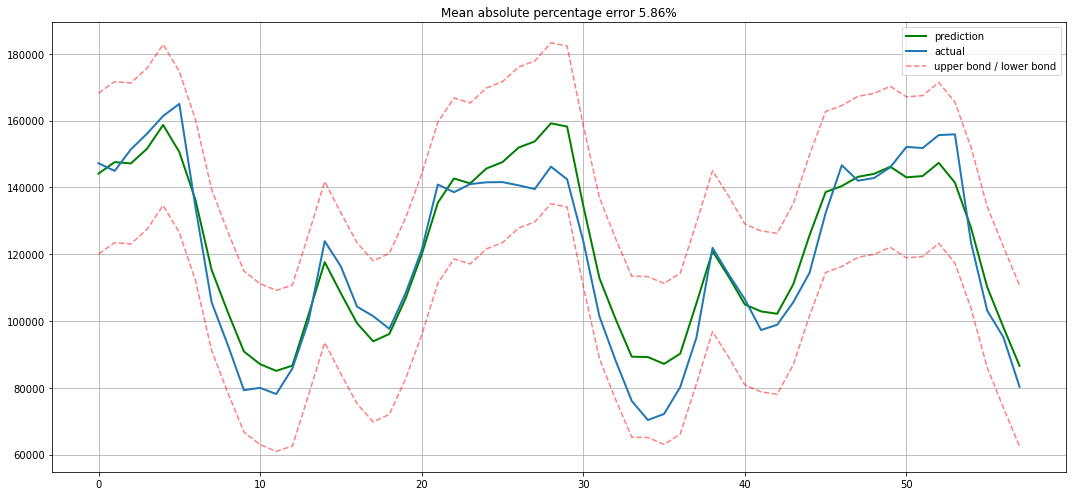

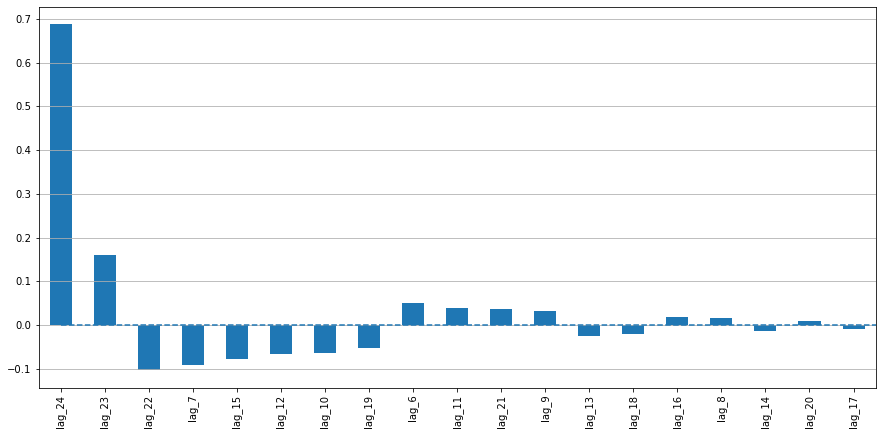

In [54]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Simple lags and linear regression gave us predictions that are not that far off from SARIMA in terms of quality. There are many unnecessary features, so we'll do feature selection in a little while. For now, let's continue engineering!

We'll add hour, day of week, and a boolean for is_weekend. To do so, we need to transform the current dataframe index into the datetime format and extract hour and weekday.

In [55]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

y     lag_6     lag_7     lag_8     lag_9    lag_10  \
Time                                                                            
2017-09-21 19:00:00  155890  141995.0  146630.0  132335.0  114380.0  105635.0   
2017-09-21 20:00:00  123395  142815.0  141995.0  146630.0  132335.0  114380.0   
2017-09-21 21:00:00  103080  146020.0  142815.0  141995.0  146630.0  132335.0   
2017-09-21 22:00:00   95155  152120.0  146020.0  142815.0  141995.0  146630.0   
2017-09-21 23:00:00   80285  151790.0  152120.0  146020.0  142815.0  141995.0   

                       lag_11    lag_12    lag_13    lag_14  ...    lag_18  \
Time                                                         ...             
2017-09-21 19:00:00   98860.0   97290.0  106495.0  113950.0  ...   72150.0   
2017-09-21 20:00:00  105635.0   98860.0   97290.0  106495.0  ...   80195.0   
2017-09-21 21:00:00  114380.0  105635.0   98860.0   97290.0  ...   94945.0   
2017-09-21 22:00:00  132335.0  114380.0  105635.0   98860.0  ...  121910.0   
2017-09-21 23:00:00  146630.0  132335.0  114380.0  105635.0  ...  113950.0   

                       lag_19   lag_20   lag_21    lag_22    lag_23    lag_24  \
Time                                                                            
2017-09-21 19:00:00   70335.0  76050.0  88170.0  101360.0  123945.0  142425.0   
2017-09-21 20:00:00   72150.0  70335.0  76050.0   88170.0  101360.0  123945.0   
2017-09-21 21:00:00   80195.0  72150.0  70335.0   76050.0   88170.0  101360.0   
2017-09-21 22:00:00   94945.0  80195.0  72150.0   70335.0   76050.0   88170.0   
2017-09-21 23:00:00  121910.0  94945.0  80195.0   72150.0   70335.0   76050.0   

                     hour  weekday  is_weekend  
Time                                            
2017-09-21 19:00:00    19        3           0  
2017-09-21 20:00:00    20        3           0  
2017-09-21 21:00:00    21        3           0  
2017-09-21 22:00:00    22        3           0  
2017-09-21 23:00:00    23        3           0  

[5 rows x 23 columns]

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization.

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

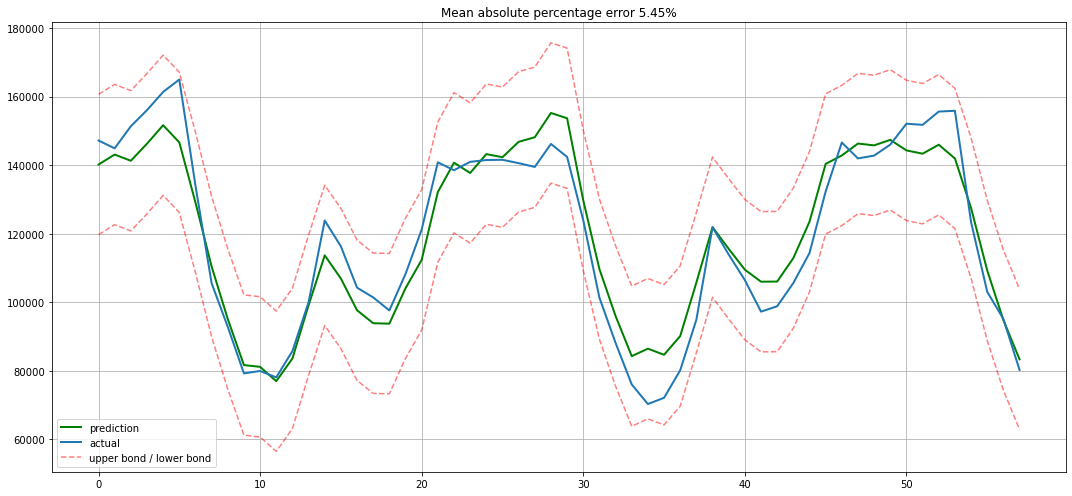

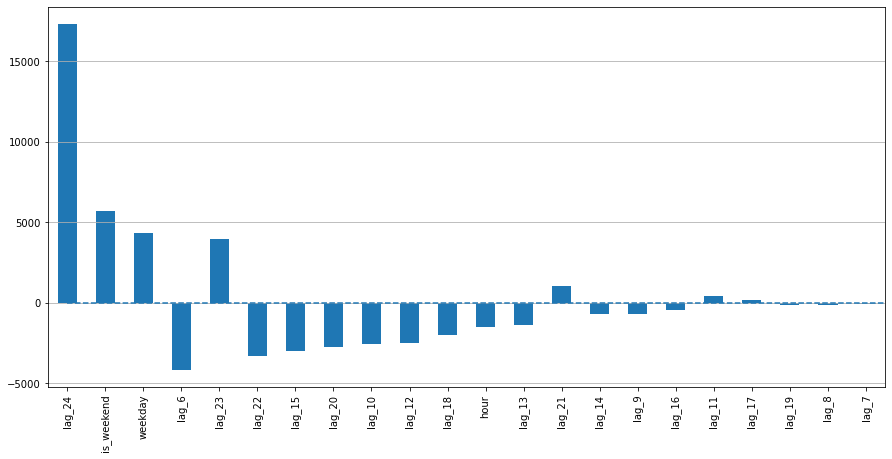

In [57]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

### Target Encoding

The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

In [58]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

<AxesSubplot:title={'center':'Hour averages'}>

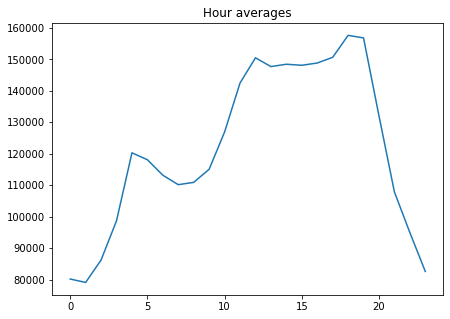

In [59]:
average_hour = code_mean(data, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()

Finally, let's put all the transformations together in a single function .

In [60]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

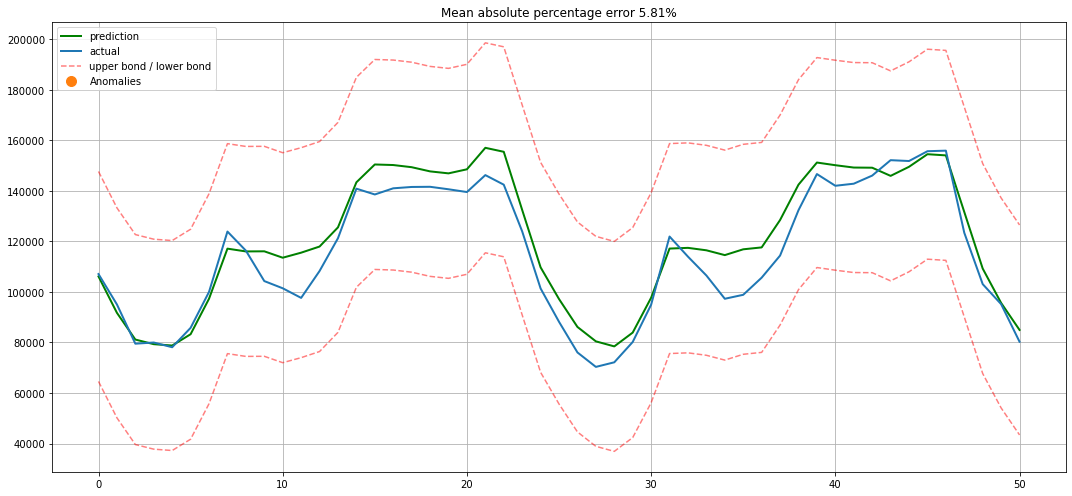

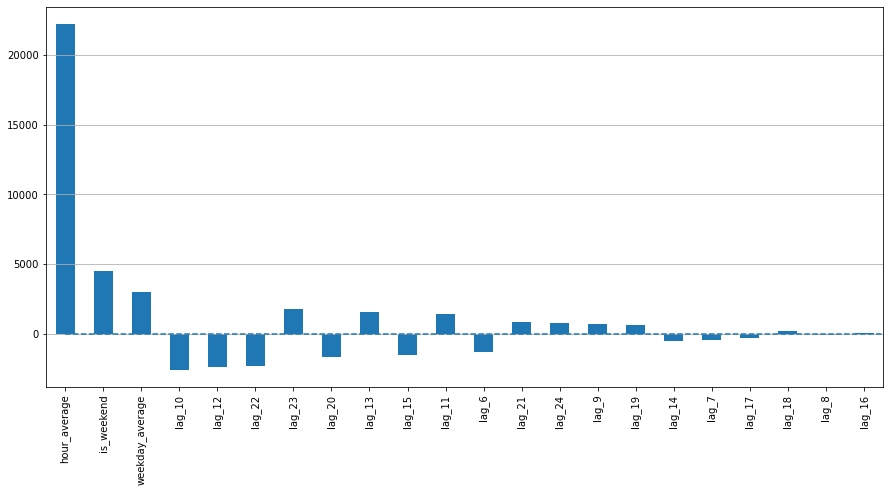

In [61]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

We see some overfitting! Hour_average was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction dropped.

In [62]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Regularization and Feature Selection

As we already know, not all features are equally usefull -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function.

First, let's make sure that we have features to drop and that the data has highly correlated features.

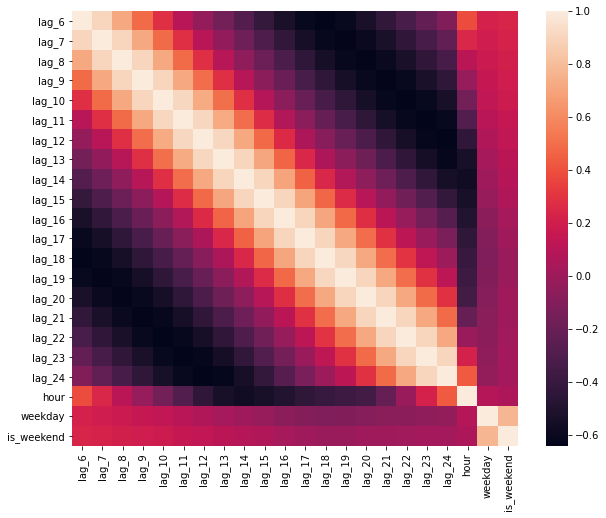

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

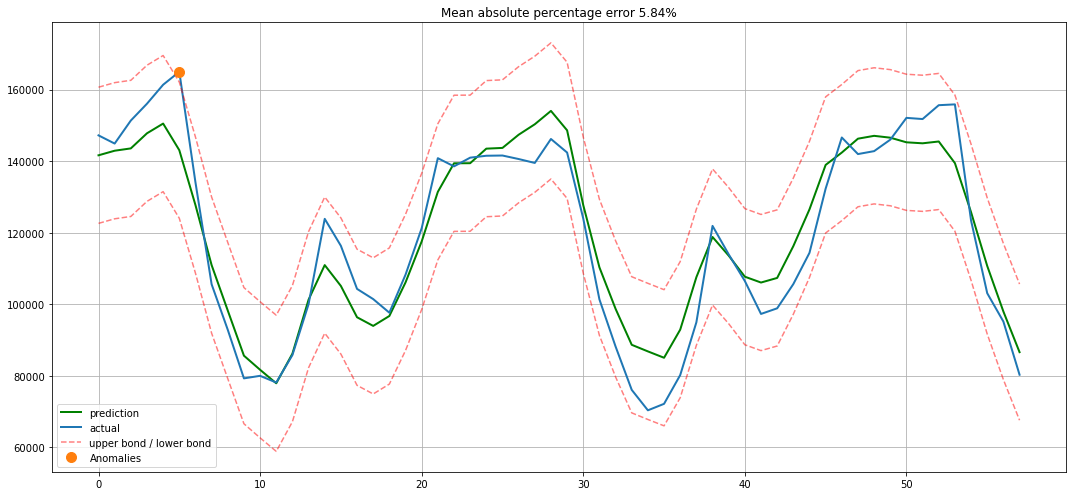

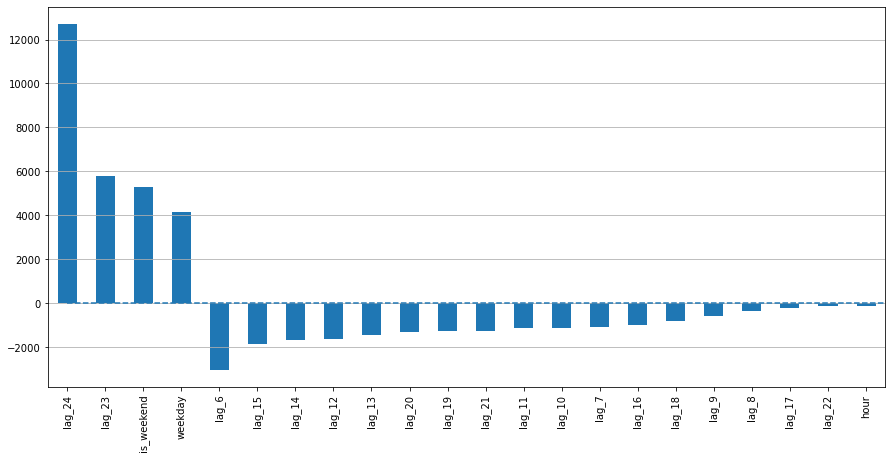

In [64]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

We can clearly see some coefficients are getting closer and closer to zero (though they never actually reach it) as their importance in the model drops.

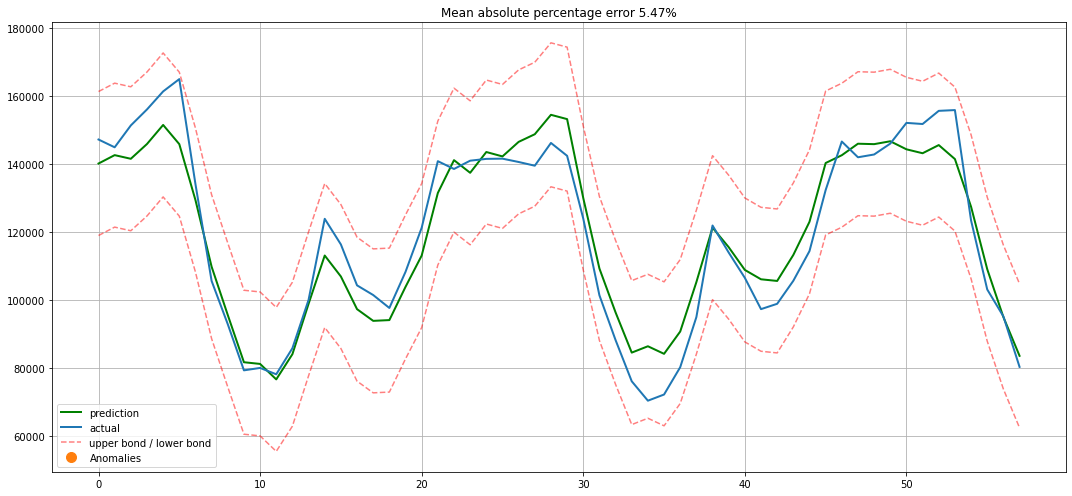

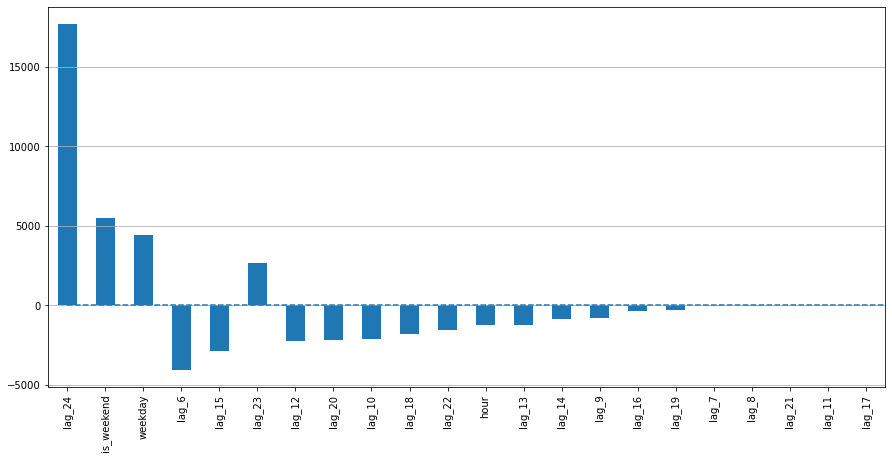

In [65]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Lasso regression turned out to be more conservative; it removed 23-rd lag from the most important features and dropped 5 features completely, which only made the quality of prediction better.

### Boosting

In [66]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

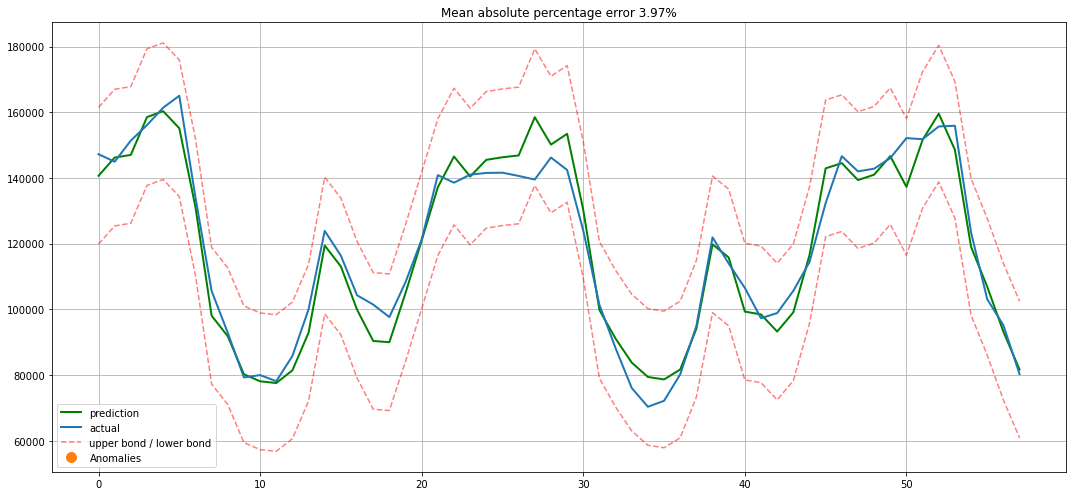

In [67]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)